![](https://github.com/sfbrigade/CA_DOJ_OpenJustice/blob/master/figure/ca_openjustice.png?raw=true)

# Objective
For the same criminal offense, are particular ethnic juvenile groups more likely to be treated with harsher consequences by law enforcement?

# Exploration
## Load CSV files from Azure into Dataframes

In [2]:
#Load DOJ arrests data from AzureML Datasets
from azureml import Workspace
ws = Workspace()
ds = ws.datasets['ca_doj_arrests_deidentified_2014_05-07-2016.csv']
frame = ds.to_dataframe()

/home/nbuser/env3/lib/python3.4/site-packages/pandas/io/parsers.py:1139: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [3]:
#View metadata
print(ds.name)
print(ds.data_type_id)
print(ds.size)
print(ds.created_date)

ca_doj_arrests_deidentified_2014_05-07-2016.csv
GenericCSV
160596366
2016-06-05 19:19:55.812000


In [4]:
#Need to fix this code to bring in all files at once, not just 2014
import glob
test = glob.glob('ca_doj_arrests_deidentified_20[00-14]_05-07-2016.csv')
#dsarrests = ws.datasets['ca_doj_arrests_deidentified_*.csv']
#framearrests = dsarrests.to_dataframe()

In [6]:
test

[]

In [7]:
#Load population data from AzureML Datasets in case it's needed later
dspop = ws.datasets['ca_county_population_by_race_gender_age_2005-2014_02-05-2016.csv']
framepop = dspop.to_dataframe()

In [8]:
#View metadata
print(dspop.name)
print(dspop.data_type_id)
print(dspop.size)
print(dspop.created_date)

ca_county_population_by_race_gender_age_2005-2014_02-05-2016.csv
GenericCSV
6588820
2016-06-06 04:30:12.356000


In [9]:
framepop.dtypes

year           int64
county        object
race          object
gender        object
age_group     object
population     int64
dtype: object

In [10]:
#Load contextual data from AzureML Datasets in case it's needed later
dscontex = ws.datasets['ca_county_agency_contextual_indicators_2009-2014_05-03-2016.csv']
framecontex = dscontex.to_dataframe()

In [11]:
#View metadata
print(dscontex.name)
print(dscontex.data_type_id)
print(dscontex.size)
print(dscontex.created_date)

ca_county_agency_contextual_indicators_2009-2014_05-03-2016.csv
GenericCSV
278930
2016-07-19 14:52:23.872000


In [12]:
framecontex.dtypes

year                       int64
county                    object
agency_name               object
agency_code               object
less_than_high_school    float64
high_school_or_higher    float64
bachelors_or_higher      float64
per_capita_income        float64
median_income            float64
poverty_rate             float64
employment_rate          float64
unemployment_rate        float64
dtype: object

In [85]:
#Load offense code dictionary data from AzureML Datasets in case it's needed later
dsoffensecodes = ws.datasets['offense_codes.csv']

## Assess if seasonality should be explored further (Juveniles only)

In [13]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
from calendar import isleap

# fix rows with arrest_day == 0
frame.loc[(frame['arrest_day'] == 0), 'arrest_day'] = 1

# fix months with 30 days that have arrest_day == 31
month_30 = [4, 6, 9, 11]
for month in month_30:
    frame.loc[(frame['arrest_month'] == month) & (frame['arrest_day'] == 31), 'arrest_day'] = 30

# Roll February arrest_day past 28 (i.e., 29, 30, 31) or 29th (i.e., 30, 31) back to max number of days
frame.loc[(frame['arrest_year'].apply(lambda x: isleap(x))) & (frame['arrest_month'] == 2) & (frame['arrest_day'] > 29), 'arrest_day'] = 29
frame.loc[~(frame['arrest_year'].apply(lambda x: isleap(x))) & (frame['arrest_month'] == 2) & (frame['arrest_day'] > 28), 'arrest_day'] = 28

In [15]:
%matplotlib inline

In [18]:
frameage = frame.loc[:,['age_group']].groupby('age_group').size().order(ascending=False)

In [32]:
frameage

age_group
adult        1126022
juvenile       86823
dtype: int64

In [33]:
#Select juvenile arrests data only
framejuv = frame.loc[frame['age_group'] == 'juvenile']

In [34]:
framejuv.dtypes

county                      object
agency_name                 object
agency_code                 object
arrest_year                  int64
arrest_month                 int64
arrest_day                   int64
race_or_ethnicity           object
gender                      object
age_group                   object
summary_offense_level       object
offense_level               object
bcs_offense_code             int64
bcs_summary_offence_code     int64
fbi_offense_code            object
status_type                 object
disposition                 object
dtype: object

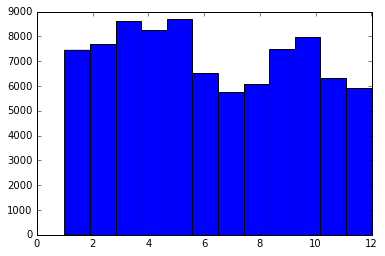

In [35]:
#Juvenile arrest by month of year
framejuv.arrest_month.hist(grid=False, bins=12)

- Notice lower numbers of arrests in summer and winter months - potential relationship with being out of school

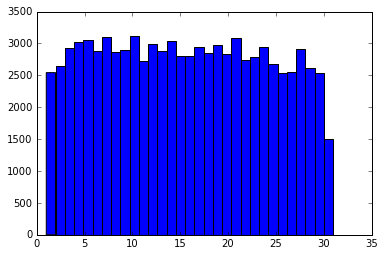

In [36]:
#Juvenile arrests by day of month
framejuv.arrest_day.hist(grid=False, bins=31)

In [26]:
#[2] returns the week day (1-7)
#todayWeekDay = date.today().isocalendar()[2]
#todayWeekDay

In [37]:
#Adding datetime and date formats
framejuv['datetime'] = pd.to_datetime(framejuv.arrest_year*10000 + framejuv.arrest_month*100 + framejuv.arrest_day, format="%Y%m%d")
framejuv['date'] = pd.DatetimeIndex(framejuv.datetime).normalize()

#Adding day of week
framejuv['week'] = pd.DatetimeIndex(framejuv['datetime']).dayofweek

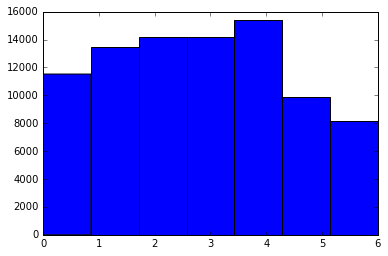

In [38]:
#Juvenile arrests by day of week
framejuv.week.hist(grid=False, bins=7)

- Higher number of arrests mid-week Wednesday through Friday

In [28]:
#Potential to model seasonality here or include seasonality as contextual factor in later predictive model
#import statsmodels.api as sm

## High level groupings

In [39]:
#Group by offense level
framejuvbyoffense = framejuv.loc[:,['offense_level']].groupby('offense_level').size().order(ascending=False)

In [40]:
#View arrests by offense level
framejuvbyoffense

offense_level
misdemeanor       48291
felony            27651
status offense    10881
dtype: int64

In [41]:
#Group by gender
framejuvbygender = framejuv.loc[:,['gender']].groupby('gender').size().order(ascending=False)

In [42]:
#View arrests by gender
framejuvbygender

gender
male      63221
female    23602
dtype: int64

In [43]:
#Group by race/ethnicity
framejuvbyrace = framejuv.loc[:,['race_or_ethnicity']].groupby('race_or_ethnicity').size().order(ascending=False)

In [44]:
#View arrests by race/ethnicity
framejuvbyrace

race_or_ethnicity
Hispanic                             35449
suppressed_due_to_privacy_concern    20596
Black                                14392
White                                12438
Asian/Pacific Islander                1988
Other                                 1960
dtype: int64

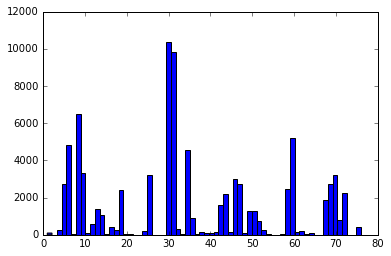

In [45]:
#Identify BCS summary offense codes with highest frequency
framejuv.bcs_summary_offence_code.hist(grid=False, bins=66)

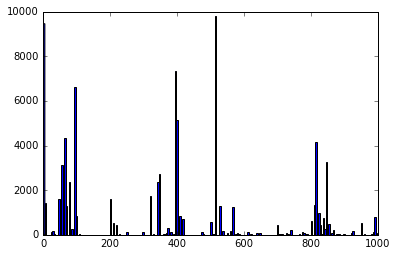

In [92]:
#Identify BCS offense codes with highest frequency
framejuv.bcs_offense_code.hist(grid=False, bins=226)

Image and selection of codes for further analysis based on offense code dictionary completed here by DSWG member Brian Smith:
https://numeracy.co/projects/B9xYvPL2Bo/summary-code-30

![](https://github.com/sfbrigade/CA_DOJ_OpenJustice/blob/master/figure/battery_bcs_offense_code_397.png?raw=true)

## More granular groupings
- Begin to explore differences in treatment of arrests for the same offense

In [46]:
#Select offense code 30
framejuv30 = framejuv.loc[framejuv['bcs_summary_offence_code'] == 30]

In [47]:
framejuvexplore0 = framejuv30.groupby(['race_or_ethnicity']).size()

In [48]:
#View race grouping for misdemeanor with BCS summary offense code 30
framejuvexplore0ind = framejuvexplore0.reset_index(name='count')

In [49]:
framejuvexplore0ind

,race_or_ethnicity,count
0,Asian/Pacific Islander,239
1,Black,2153
2,Hispanic,3758
3,Other,184
4,White,1424
5,suppressed_due_to_privacy_concern,2585


In [50]:
framejuvexplore1 = framejuv30.groupby(['bcs_summary_offence_code', 'disposition', 'race_or_ethnicity']).size()

In [51]:
framejuvexplore1ind = framejuvexplore1.reset_index(name='count')

In [52]:
framejuvexplore1ind

,bcs_summary_offence_code,disposition,race_or_ethnicity,count
0,30,handled within department,Asian/Pacific Islander,41
1,30,handled within department,Black,395
2,30,handled within department,Hispanic,540
3,30,handled within department,Other,29
4,30,handled within department,White,237
5,30,handled within department,suppressed_due_to_privacy_concern,194
6,30,referred to juvenile probation department,Asian/Pacific Islander,197
7,30,referred to juvenile probation department,Black,1729
8,30,referred to juvenile probation department,Hispanic,3170
9,30,referred to juvenile probation department,Other,152


In [53]:
framejuvexplore2 = framejuv30.groupby(['bcs_summary_offence_code', 'status_type', 'race_or_ethnicity']).size()

In [54]:
framejuvexplore2ind = framejuvexplore2.reset_index(name='count')

In [55]:
framejuvexplore2ind

,bcs_summary_offence_code,status_type,race_or_ethnicity,count
0,30,booked,Asian/Pacific Islander,83
1,30,booked,Black,1146
2,30,booked,Hispanic,1973
3,30,booked,Other,82
4,30,booked,White,682
5,30,booked,suppressed_due_to_privacy_concern,1380
6,30,cited,Asian/Pacific Islander,118
7,30,cited,Black,736
8,30,cited,Hispanic,1161
9,30,cited,Other,74


An arrest means incarceration at the jail till your appearance date, or bail, or booked and released with a court date. A misdemeanor citation is a criminal ticket with a court date where you have not been booked at the county jail. Need to confirm below whether booked refers to heavier form of treatment than cited.

In [56]:
framejuvexplore3 = pd.merge(framejuvexplore0ind, framejuvexplore2ind, how='inner', on=['race_or_ethnicity', 'race_or_ethnicity'])

In [57]:
framejuvexplore3['rate'] = framejuvexplore3['count_y'] / framejuvexplore3['count_x']

In [58]:
framejuvexplore3

,race_or_ethnicity,count_x,bcs_summary_offence_code,status_type,count_y,rate
0,Asian/Pacific Islander,239,30,booked,83,0.347280
1,Asian/Pacific Islander,239,30,cited,118,0.493724
2,Asian/Pacific Islander,239,30,other,38,0.158996
3,Black,2153,30,booked,1146,0.532281
4,Black,2153,30,cited,736,0.341849
5,Black,2153,30,other,271,0.125871
6,Hispanic,3758,30,booked,1973,0.525013
7,Hispanic,3758,30,cited,1161,0.308941
8,Hispanic,3758,30,other,624,0.166046
9,Other,184,30,booked,82,0.445652


In [59]:
framejuvexplore4 = framejuv30.groupby(['race_or_ethnicity', 'arrest_month']).size()
framejuvexplore4ind = framejuvexplore4.reset_index(name='count')
framejuvexplore5 = framejuv30.groupby(['bcs_summary_offence_code', 'status_type', 'race_or_ethnicity', 'arrest_month']).size()
framejuvexplore5ind = framejuvexplore5.reset_index(name='count')
framejuvexplore6 = pd.merge(framejuvexplore4ind, framejuvexplore5ind, how='inner', on=['race_or_ethnicity', 'arrest_month'])
framejuvexplore6['rate'] = framejuvexplore6['count_y'] / framejuvexplore6['count_x']

In [61]:
framejuvexplore6asian = framejuvexplore6.loc[framejuvexplore6['race_or_ethnicity'] == 'Asian/Pacific Islander']
framejuvexplore6asianbooked = framejuvexplore6asian.loc[framejuvexplore6asian['status_type'] == 'booked']

In [62]:
framejuvexplore6asianbooked

,race_or_ethnicity,arrest_month,count_x,bcs_summary_offence_code,status_type,count_y,rate
0,Asian/Pacific Islander,1,24,30,booked,10,0.416667
3,Asian/Pacific Islander,2,31,30,booked,15,0.483871
6,Asian/Pacific Islander,3,24,30,booked,10,0.416667
9,Asian/Pacific Islander,4,28,30,booked,12,0.428571
12,Asian/Pacific Islander,5,20,30,booked,6,0.300000
15,Asian/Pacific Islander,6,12,30,booked,4,0.333333
18,Asian/Pacific Islander,7,8,30,booked,2,0.250000
21,Asian/Pacific Islander,8,10,30,booked,3,0.300000
24,Asian/Pacific Islander,9,20,30,booked,4,0.200000
27,Asian/Pacific Islander,10,28,30,booked,5,0.178571


In [63]:
framejuvexplore6black = framejuvexplore6.loc[framejuvexplore6['race_or_ethnicity'] == 'Black']
framejuvexplore6blackbooked = framejuvexplore6black.loc[framejuvexplore6black['status_type'] == 'booked']

In [64]:
framejuvexplore6blackbooked

,race_or_ethnicity,arrest_month,count_x,bcs_summary_offence_code,status_type,count_y,rate
36,Black,1,170,30,booked,78,0.458824
39,Black,2,220,30,booked,107,0.486364
42,Black,3,219,30,booked,117,0.534247
45,Black,4,199,30,booked,112,0.562814
48,Black,5,257,30,booked,132,0.513619
51,Black,6,143,30,booked,72,0.503497
54,Black,7,112,30,booked,74,0.660714
57,Black,8,109,30,booked,63,0.577982
60,Black,9,192,30,booked,97,0.505208
63,Black,10,209,30,booked,114,0.545455


In [65]:
framejuvexplore6hispanic = framejuvexplore6.loc[framejuvexplore6['race_or_ethnicity'] == 'Hispanic']
framejuvexplore6hispanicbooked = framejuvexplore6hispanic.loc[framejuvexplore6hispanic['status_type'] == 'booked']

In [59]:
framejuvexplore6hispanicbooked

,race_or_ethnicity,arrest_month,count_x,bcs_summary_offence_code,status_type,count_y,rate
72,Hispanic,1,290,30,booked,142,0.489655
75,Hispanic,2,306,30,booked,156,0.509804
78,Hispanic,3,400,30,booked,205,0.512500
81,Hispanic,4,339,30,booked,177,0.522124
84,Hispanic,5,411,30,booked,225,0.547445
87,Hispanic,6,248,30,booked,136,0.548387
90,Hispanic,7,188,30,booked,116,0.617021
93,Hispanic,8,257,30,booked,149,0.579767
96,Hispanic,9,381,30,booked,189,0.496063
99,Hispanic,10,357,30,booked,185,0.518207


In [66]:
framejuvexplore6white = framejuvexplore6.loc[framejuvexplore6['race_or_ethnicity'] == 'White']
framejuvexplore6whitebooked = framejuvexplore6white.loc[framejuvexplore6white['status_type'] == 'booked']

In [125]:
framejuvexplore6whitebooked

,race_or_ethnicity,arrest_month,count_x,bcs_summary_offence_code,status_type,count_y,rate
141,White,1,102,30,booked,55,0.539216
144,White,2,125,30,booked,55,0.440000
147,White,3,146,30,booked,67,0.458904
150,White,4,129,30,booked,61,0.472868
153,White,5,143,30,booked,62,0.433566
156,White,6,111,30,booked,56,0.504505
159,White,7,80,30,booked,49,0.612500
162,White,8,91,30,booked,52,0.571429
165,White,9,136,30,booked,59,0.433824
168,White,10,146,30,booked,64,0.438356


##Normality Test
The Shapiro-Wilk normality test tests for differences between the observed distribution and normal distribution. If the p-value is greater than 5%, then the test does not reject the null hypothesis that the samples came from a normal distribution.

In [67]:
from scipy import stats
stats.shapiro(framejuvexplore6asianbooked.rate)

(0.9529476761817932, 0.6803945899009705)

In [68]:
stats.shapiro(framejuvexplore6blackbooked.rate)

(0.9557058811187744, 0.7212318181991577)

In [69]:
stats.shapiro(framejuvexplore6hispanicbooked.rate)

(0.9023861289024353, 0.170271635055542)

In [70]:
stats.shapiro(framejuvexplore6whitebooked.rate)

(0.8942013382911682, 0.13350442051887512)

##Mean

In [76]:
np.mean(framejuvexplore6asianbooked.rate)

0.34035310567568633

In [73]:
np.mean(framejuvexplore6blackbooked.rate)

0.5387842921179384

In [74]:
np.mean(framejuvexplore6hispanicbooked.rate)

0.5291145914266602

In [75]:
np.mean(framejuvexplore6whitebooked.rate)

0.4880568639773168

##Two-Sample T-Test (Summary Offense Group Level)
In a two-sample test, the null hypothesis is that the means of both groups are the same. For our tests: If the p-value is smaller than 5%, then we reject the null hypothesis of equal averages.

In [77]:
stats.ttest_ind(a= framejuvexplore6asianbooked.rate,
                b= framejuvexplore6blackbooked.rate,
                equal_var=False) 

Ttest_indResult(statistic=-5.3884798074962781, pvalue=6.6357601573991158e-05)

There is an extremely low chance (0.007%) we'd see sample data this far apart if the two groups tested are actually identical. There is a significant difference in booked rates between Asian and Black ethnicities.

In [78]:
stats.ttest_ind(a= framejuvexplore6hispanicbooked.rate,
                b= framejuvexplore6blackbooked.rate,
                equal_var=False) 

Ttest_indResult(statistic=-0.50487665610907295, pvalue=0.61917171092199319)

There is a 61.92% chance we'd see sample data this far apart. There is no significant difference in booked rates between Black and Hispanic ethnicities.

In [79]:
stats.ttest_ind(a= framejuvexplore6whitebooked.rate,
                b= framejuvexplore6blackbooked.rate,
                equal_var=False) 

Ttest_indResult(statistic=-2.114669104941119, pvalue=0.046322051250721807)

There is a 4.6% chance we'd see sample data this far apart. There is a significant difference in booked rates between White and Black ethnicities.

In [80]:
stats.ttest_ind(a= framejuvexplore6whitebooked.rate,
                b= framejuvexplore6asianbooked.rate,
                equal_var=False) 

Ttest_indResult(statistic=3.8819257423387472, pvalue=0.0011927053701213388)

There is a 0.12% chance we'd see sample data this far apart. There is a significant difference in booked rates between White and Asian ethnicities.

###For the same summary criminal offense of misdemeanor summary offense code 30, black and hispanic ethnic juvenile groups are more likely to be booked (treated with harsher consequences by law enforcement) than white and asian juvenile groups.

##Two-Sample T-Test (Offense Group Level)
In a two-sample test, the null hypothesis is that the means of both groups are the same. For our tests: If the p-value is smaller than 5%, then we reject the null hypothesis of equal averages.

In [93]:
framejuv397 = framejuv.loc[framejuv['bcs_offense_code'] == 397]
framejuv397explore1 = framejuv397.groupby(['race_or_ethnicity', 'arrest_month']).size()
framejuv397explore1ind = framejuv397explore1.reset_index(name='count')
framejuv397explore2 = framejuv397.groupby(['bcs_offense_code', 'status_type', 'race_or_ethnicity', 'arrest_month']).size()
framejuv397explore2ind = framejuv397explore2.reset_index(name='count')
framejuv397merged = pd.merge(framejuv397explore1ind, framejuv397explore2ind, how='inner', on=['race_or_ethnicity', 'arrest_month'])
framejuv397merged['rate'] = framejuv397merged['count_y'] / framejuv397merged['count_x']

framejuv397asian = framejuv397merged.loc[framejuv397merged['race_or_ethnicity'] == 'Asian/Pacific Islander']
framejuv397asianbooked = framejuv397asian.loc[framejuv397asian['status_type'] == 'booked']

framejuv397black = framejuv397merged.loc[framejuv397merged['race_or_ethnicity'] == 'Black']
framejuv397blackbooked = framejuv397black.loc[framejuv397black['status_type'] == 'booked']

framejuv397hispanic = framejuv397merged.loc[framejuv397merged['race_or_ethnicity'] == 'Hispanic']
framejuv397hispanicbooked = framejuv397hispanic.loc[framejuv397hispanic['status_type'] == 'booked']

framejuv397white = framejuv397merged.loc[framejuv397merged['race_or_ethnicity'] == 'White']
framejuv397whitebooked = framejuv397white.loc[framejuv397white['status_type'] == 'booked']

In [94]:
np.mean(framejuv397asianbooked.rate)

0.2612832633053221

In [87]:
np.mean(framejuv397blackbooked.rate)

0.5356405345727117

In [88]:
np.mean(framejuv397hispanicbooked.rate)

0.5426319278358734

In [89]:
np.mean(framejuv397whitebooked.rate)

0.47837810668522845

In [95]:
stats.ttest_ind(a= framejuv397asianbooked.rate,
                b= framejuv397blackbooked.rate,
                equal_var=False) 

Ttest_indResult(statistic=-5.5392092290941921, pvalue=3.4523891569952856e-05)

There is an extremely low chance (0.003%) we'd see sample data this far apart if the two groups tested are actually identical. There is a significant difference in booked rates between Asian and Black ethnicities for battery.

In [97]:
stats.ttest_ind(a= framejuv397whitebooked.rate,
                b= framejuv397blackbooked.rate,
                equal_var=False) 

Ttest_indResult(statistic=-1.6561258081264065, pvalue=0.11190568038389537)

There is a 11.2% chance we'd see sample data this far apart if the two groups tested are actually identical. There is no significant difference in booked rates between White and Black ethnicities for battery.

In [83]:
stats.ttest_ind(a= framejuv397whitebooked.rate,
                b= framejuv397hispanicbooked.rate,
                equal_var=False)

Ttest_indResult(statistic=-2.0466466247499322, pvalue=0.053603469020075005)

There is a 5.3% chance we'd see sample data this far apart if the two groups tested are actually identical. There is borderline no significant different booked rates between White and Hispanic ethnicities for battery.

In [84]:
stats.ttest_ind(a= framejuv397whitebooked.rate,
                b= framejuv397asianbooked.rate,
                equal_var=False)

Ttest_indResult(statistic=4.3500553619250795, pvalue=0.00040797774982880849)

There is a 0.04% chance we'd see sample data this far apart if the two groups tested are actually identical. There is a significant difference in booked rates between White and Asian ethnicities for battery.

In [85]:
stats.ttest_ind(a= framejuv397blackbooked.rate,
                b= framejuv397hispanicbooked.rate,
                equal_var=False)

Ttest_indResult(statistic=-0.22704356339656925, pvalue=0.82258839600020572)

There is a 82.3% chance we'd see sample data this far apart. There is no significant difference in booked rates between Black and Hispanic ethnicities for battery.

###For the same criminal offense of battery (offense code 397), white, black and hispanic ethnic juvenile groups are more likely to be booked (treated with harsher consequences by law enforcement) than asian juvenile groups. There is no significant difference between black and hispanic juvenile groups, and there is borderline difference between white and hispanic juvenile groups.